# Solution - Problem Set 1

## Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz

###Import data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir -p datashim
!cp /content/drive/Shareddrives/DS602-F22/Data/data602.py ./datashim
from datashim import data602

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cdf = data602.read_citations()
wdf = data602.read_weather()

TypeError: ignored

## Question 1

###a. Over the entire datasets, which observations had the hottest and coldest temperatures? What were those temperatures?

In [ ]:
extrema = list(wdf["tmp_meas"].agg(["min", "max"]))
wdf[wdf["tmp_meas"].isin(extrema)][["date", "tmp_meas"]]

,date,tmp_meas
17694,2018-01-07 04:54:00-05:00,-16.1
17696,2018-01-07 06:54:00-05:00,-16.1
39893,2020-07-20 16:54:00-04:00,37.8


### Alternative approach:

In [ ]:
rnk = wdf["tmp_meas"].rank()
extrema = [rnk.max(), rnk.min()]
wdf[rnk.isin(extrema)][["date", "tmp_meas"]]

,date,tmp_meas
17694,2018-01-07 04:54:00-05:00,-16.1
17696,2018-01-07 06:54:00-05:00,-16.1
39893,2020-07-20 16:54:00-04:00,37.8


### Alternative (more performant) approach:

In [ ]:
def n_extrema(df, n, col):
  return pd.concat(
      [df.nlargest(n, col, keep="all").assign(extreme="max"),
      df.nsmallest(n, col, keep="all").assign(extreme="min")]
  )

n_extrema(wdf, 1, "tmp_meas")[["date", "tmp_meas", "extreme"]]

,date,tmp_meas,extreme
39893,2020-07-20 16:54:00-04:00,37.8,max
17694,2018-01-07 04:54:00-05:00,-16.1,min
17696,2018-01-07 06:54:00-05:00,-16.1,min


The hottest temperature observed was **37.8°C** (100.°F) on **July 20, 2020** at 16:54.  The coldest was **-16.1°C** (3.02°F) on **January 7, 2018**.  This value was recorded at both 4:54 and 6:54 that day.


### b. In 2020, what month had the hottest average temperature? The coldest?

In [ ]:
# Assume local time zone.  Use the `to_period` method to group by calendar month
# and get mean for each month.  We can ignore the time zone warning.
meantmp = (wdf[wdf.date.dt.year == 2020]
           .groupby(wdf["date"].dt.to_period("M"))
           .agg({"tmp_meas": "mean"}))
# As in (a), get the mean and max values
meantmp.sort_values("tmp_meas").iloc[[0, -1]]

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,tmp_meas
date,
2020-12,4.250000
2020-07,27.809005


The hottest month in 2020 was **July 2020**, when the average temperature was 27.8°C (82.0°F).  The coldest month of the year was **December**, averaging 4.25°C (40°F).

Alternatively, we can obtain the same result without using series like so:

In [ ]:
meantmp = (
    wdf[wdf.date.dt.year == 2020]
    .assign(month = wdf["date"].dt.month, year=wdf["date"].dt.year)
    .groupby(["month", "year"])
    .agg({"tmp_meas": "mean"})
)

meantmp.loc[[meantmp["tmp_meas"].idxmax(), 
             meantmp["tmp_meas"].idxmin()]]

,,tmp_meas
month,year,
7,2020,27.809005
12,2020,4.250000


### c. In 2020, how many days were associated with rain (i.e., liquid precipitation exceeding zero for at least one observation)?

In [ ]:
rainobs = wdf[(wdf["date"].dt.year == 2020) & (wdf["precip"] > 0)]
rainobs["date"].dt.date.unique().shape

(144,)

144 days in 2020 were associated with rain.

##Question 2

###a. Which violation types, on average, incur the highest fines?

In [ ]:
# We can get the fines by violation type like so:
(cdf
 .groupby("description")["violfine"]
 .agg("mean")
 .sort_values(ascending=False)
 .head(8) 
 # format as currency, if we wish
 .map("${0:.2f}".format))

description
No Parking/Standing Vendor Truck                  $502.00
Unlawful Dumping/Waste Hauler w/o Permit          $502.00
No Stop/Park Handicap                             $489.26
Commercial Veh/Residence over 20,000 lbs          $474.64
Abandonded Vehicle                                $279.43
Commercial Vehicle Obstruct/Imped Traffic Flow    $252.00
Obstructing/Imped Traffic Xwalk/inter/school      $252.00
No Parking/Standing In Bus Stop/Bus Lane          $252.00
Name: violfine, dtype: object

The violation types incurring the highest fines are No Parking/Standing Vendor Truck and Unlawful Dumping, both averaging a fine of $502.

###b. In 2020, which violation type was the most common? What percentage of total citations issued that year did it comprise?

In [ ]:
cdf2020 = cdf[cdf.violdate.dt.year == 2020].copy()
(cdf2020["description"]
 .value_counts(normalize=True)
 .map(lambda z: "%0.2f%%"%(z*100))
 .head(4))


Fixed Speed Camera                    60.35%
Red Light Violation                   11.03%
Right on Red                          10.74%
All Other Parking Meter Violations     6.32%
Name: description, dtype: object

The most common violation in 2020 was **Fixed Speed Camera**, which comprised **60.3%** of violations that year.

###c. In 2020, which violation type was responsible for the highest fine revenue (i.e., highest sum of fine amounts)? What percentage of total fine revenue did it comprise for the year?


In [ ]:
# use cdf2020 from (b)

(cdf2020[["description", "violfine"]]
  .groupby("description")
  .agg("sum")
  # transform to column percentages
  .transform(lambda k: k/sum(k))
  .sort_values("violfine", ascending=False)
  # format as percentage
  .applymap(lambda k: "{0:.2f}%".format(100 * k))
  .head(5)
  )

,violfine
description,
Fixed Speed Camera,48.28%
Red Light Violation,16.55%
Right on Red,16.11%
All Other Parking Meter Violations,4.04%
No Parking/Standing In Bus Stop/Bus Lane,3.14%


In 2020, the violation type **Fixed Speed Camera** was responsible for almost half (48.3%) of all fine revenue.  

###d. Show the fines charged against the 10 tags (license plates) with the highest total fines assessed in 2020. For each, show the total number of citations, and mean/standard deviation of the fine amount.

In [ ]:
# use cdf2020 from (b)
# add sttag column (tag is keyed by state and tag number)
cdf2020['sttag'] = cdf2020['state'].astype(str) + '/' + cdf2020['tag']

tbl = (cdf2020
       .groupby("sttag")["violfine"]
       .agg(["sum", "count", "mean", "std"])
       .sort_values("sum", ascending=False)
       .head(10))

# format table values to make suitable for presentation
formatkeys = {"sum": "${0:,.2f}", "mean": "${0:.2f}", "std": "${0:.2f}"}
for col, fmt in formatkeys.items():
  tbl[col] = tbl[col].map(fmt.format)
tbl

,sum,count,mean,std
sttag,,,,
MD/A354123,"$5,895.00",143,$41.22,$6.45
MD/9DR2114,"$4,740.00",101,$46.93,$14.02
MD/6EE1679,"$4,630.00",86,$53.84,$17.21
VA/URX4846,"$4,421.00",76,$58.17,$16.19
MD/4CXM25,"$4,365.00",96,$45.47,$12.77
PA/RR5H74,"$4,237.00",86,$49.27,$16.15
MD/NO TAGST,"$4,011.00",108,$37.14,$10.42
MD/8DW4455,"$3,980.00",89,$44.72,$12.02
MD/2CC3046,"$3,882.00",88,$44.11,$11.20


The ten tags with the highest total assessed fines, and corresponding summary statistics, are shown in the listing above.

###e. Due to accuracy concerns, Baltimore City suspended fixed speed camera enforcement for a multiyear period that is covered by the dataset. Using the data, show when the hiatus began and when citations resumed.

In [ ]:
# get dataset filtering timestamps of speed camera violations
# (code 32); use cdf[["violcode", "description"]].value_counts() to confirm
cds = cdf[cdf['violcode']==32][["violdate"]].sort_values('violdate')

# shift 1 to get prior timestamp
cds["priorvioldate"] = cds["violdate"].shift(1)
(cds
 .assign(delta = cds["violdate"] - cds["priorvioldate"])
 .sort_values("delta", ascending=False)
 .head(3))

,violdate,priorvioldate,delta
3823103,2017-07-31 06:00:00-04:00,2012-12-31 14:09:00-05:00,1672 days 14:51:00
3973623,2010-02-17 11:34:00-05:00,2010-01-12 12:32:00-05:00,35 days 23:02:00
3883186,2009-12-17 11:29:59-05:00,2009-12-04 13:05:00-05:00,12 days 22:24:59


The dataset shows that no fixed speed camera citations were issued between January 1, 2013 and July 30, 2017.

### Alternate solution
The question indicates the presence of an enforcement gap covering a multi-year period.  We can examine the dataset to find gaps visually (e.g., through a density plot) or by identifying years that are not associated with any observations.

In [ ]:
cds = (
    cdf[cdf['violcode']==32][["violdate"]]
    .sort_values('violdate')
    .reset_index(drop=True) # order index by observation date, used later
    ) 
cds.assign(yr = cds['violdate'].dt.year).yr.value_counts(sort=False)

2009         5
2010       525
2011     44810
2012     52069
2017    170260
2018    439495
2019    478507
2020    597338
2021    432836
2022    334620
Name: yr, dtype: int64

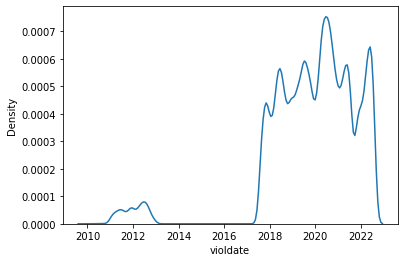

In [ ]:
sns.kdeplot(data=cds, x="violdate")

Either approach shows no citations in the years 2013-2016.  Given this, we can find observations surrounding the gap.  Taking 2014 arbitarily from the gap period, we can find the last observation before 2014 and first after to obtain the same result.

In [ ]:
idx = cds[cds['violdate'].dt.year < 2014].violdate.idxmax()
cds.iloc[[idx, idx+1],:]

,violdate
97408,2012-12-31 14:09:00-05:00
97409,2017-07-31 06:00:00-04:00


## Question 3

Answers will vary, but should show a pattern produced from exploration that is novel, nontrivial, and potentially useful.

## Question 4

CRISP-DM is useful for data science efforts where a data initiative has a clear business goal that translates into a clear data mining goal.  For data science
efforts that do not meet this criteria, an alternative trajectory may prove
more suitable.  For instance, a data exploration activity that does not involve
modeling may not be well-suited for CRISP-DM.

# Question 5
Answers will vary